# GlobalSVD
This code shows as simple way to:
- Read in a .nc file using xarray
- calculate monthly global fluxes
- Generate montly anomalies from climatology of monthly means
- detrend data in first and last 3 decates
- calculate singular value decomposition, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils
import SVD_tools as svd
import segment as sg
import scipy                    # Try scipy to detrend
from scipy import signal
from scipy.stats import spearmanr
import warnings

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

In [2]:
# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# TODO, turn warmings back on with code below? 
#warnings.resetwarnings()

## Read in data

In [3]:
variables = ['GPP','TBOT','SOILLIQ', 'NBP']  #TWS not available for CESM1 / CLM4

# --- CESM2 hist (1 ensemble member) ---
#model = 'CESM2_hist1'
#pattern = '/glade/collections/cdg/timeseries-cmip6/b.e21.BHIST.f09_g17.CMIP6-historical.001/' \
#    'lnd/proc/tseries/month_1/b.e21.BHIST.f09_g17.CMIP6-historical.001.clm2.h0.{var}.185001-201412.nc'


# --- CESM1-LENS hist (1 ensemble member) ---
#model = 'CESM1_LENS1'
#pattern = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/lnd/proc/tseries/monthly/' \
#    '{var}/b.e11.B20TRC5CNBDRD.f09_g16.001.clm2.h0.{var}.185001-200512.nc'

# --- CLM5 w/ GSWP3 ---
model = 'CLM5_GSWP3'
pattern = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'\
    'lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.{var}.185001-201412.nc'

# --- CLM45 w/ GSWP3 ---
#model ='CLM45_GSWP3'
#pattern = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM4.5/clm45_r270_1deg_GSWP3V1_hist/'\
#    'lnd/proc/tseries/month_1/clm45_r270_1deg_GSWP3V1_hist.clm2.h0.{var}.185001-201412.nc'

# --- CLM40 w/ GSWP3 ---
# NO TWS output!!
#model ='CLM4_GSWP3'
#pattern = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM4/clm40_r270_1deg_GSWP3v1_CMIP6_hist/'\
#    'lnd/proc/tseries/month_1/clm40_r270_1deg_GSWP3v1_CMIP6_hist.clm2.h0.{var}.185001-201412.nc'

file = [pattern.format(var=var) for var in variables]
print(file[1])

# would be nice to just do this in a loop...
var = variables #redundant, but 'var' is used more later on...
ds0 = utils.time_set_mid(xr.open_dataset(file[0], decode_times=True), 'time')
ds1 = utils.time_set_mid(xr.open_dataset(file[1], decode_times=True), 'time')
ds2 = utils.time_set_mid(xr.open_dataset(file[2], decode_times=True), 'time')
ds3 = utils.time_set_mid(xr.open_dataset(file[3], decode_times=True), 'time')
if variables[2] == 'SOILLIQ':
    dim_lev = ds2[var[2]].dims[1]
    ds2 = ds2.sum(dim=dim_lev)
    
ds  = xr.merge([ds0, ds1, ds3],compat='override')
ds[var[2]] = ds2[var[2]]
ds['TBOT'] = ds.TBOT - 273.15
area = ds.area
landfrac = ds.landfrac

/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.TBOT.185001-201412.nc


In [4]:
years = 20
months = years * 12
ds['land_area'] = ds.area*ds.landfrac*1e6 #km2-->m2
ds.land_area.attrs['units']=cf.Unit('m^2')

ds['GPP'] = ds.GPP * 24 * 60 * 60     # g/m2/s --> g/m2/d
ds['NBP'] = ds.NBP * 24 * 60 * 60     # g/m2/s --> g/m2/d
ds.GPP.attrs['units']= 'gC/m2/d'
ds.NBP.attrs['units']= 'gC/m2/d'
ds.TBOT.attrs['units']= 'deg C'
    
ds  = ds.where(ds.GPP.max(dim='time'))  # mask out regions with no GPP for all variables

In [5]:
y = np.zeros(4)
y[0] = ds['time.year'].min() 
y[1] = ds['time.year'].min() + years 
y[2] = ds['time.year'].max()-years
y[3] = ds['time.year'].max()
print(y)

[1850. 1870. 1994. 2014.]


In [6]:

f_time = (ds['time.year']>=y[0])&(ds['time.year']<y[1])
l_time = (ds['time.year']>y[2])&(ds['time.year']<=y[3])
#ix_time1 = ix_time
f_years = np.unique((ds['time.year'][f_time]).values)
l_years = np.unique((ds['time.year'][l_time]).values)

temp_f = (ds.land_area * ds.GPP[f_time,:,:]).sum(dim=('lat','lon'))*1e-15
temp_l = (ds.land_area * ds.GPP[l_time,:,:]).sum(dim=('lat','lon'))*1e-15

ds_f = xr.Dataset(coords={'time': temp_f.time})
ds_l = xr.Dataset(coords={'time': temp_l.time})
print(ds_f)

<xarray.Dataset>
Dimensions:  (time: 240)
Coordinates:
  * time     (time) object 1850-01-16 11:45:00 ... 1869-12-16 12:00:00
Data variables:
    *empty*


In [7]:
for i in range(4):         #loop through variables
    if var[i] == 'TBOT':
        wgt = ds.land_area / ds.land_area.sum(dim=('lat','lon'))
        ds_f[var[i]] = (wgt * ds.TBOT[f_time,:,:]).sum(dim=('lat','lon'))
        ds_l[var[i]] = (wgt * ds.TBOT[l_time,:,:]).sum(dim=('lat','lon'))
    else:         
        # convert units 
        # 1e-15 for g to Pg * kg --> Tt        
        ds_f[var[i]] = (ds.land_area * ds[var[i]][f_time,:,:]).sum(dim=('lat','lon')) * 1e-15
        ds_l[var[i]] = (ds.land_area * ds[var[i]][l_time,:,:]).sum(dim=('lat','lon')) * 1e-15


In [8]:
print(ds_l)

<xarray.Dataset>
Dimensions:  (time: 240)
Coordinates:
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    GPP      (time) float32 0.22671103 0.22566503 ... 0.2496922 0.25354782
    TBOT     (time) float32 6.231383 7.9394736 10.213858 ... 10.193037 7.4924893
    SOILLIQ  (time) float32 201.74818 201.51501 ... 207.49245 205.62424
    NBP      (time) float32 -0.012132293 -0.01062505 ... -0.013030757


anomalies have to be calculated manually becase time dims are not the same

GPP = 97.76300251483917
TBOT = 13.890307


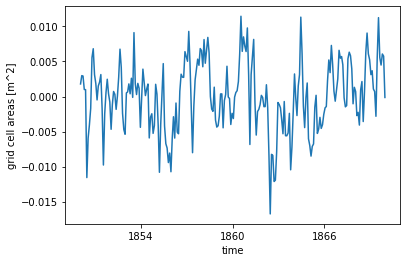

In [9]:
ds_climF = ds_f.copy(deep=True)
ds_climL = ds_l.copy(deep=True)

for i in range(years):
    iya = int(12*i)
    iyb = int(iya+12)
    for v in range(4):
        ds_climF[var[v]][iya:iyb] = ds_f[var[v]].groupby("time.month").mean("time") 
        ds_climL[var[v]][iya:iyb] = ds_l[var[v]].groupby("time.month").mean("time") 


ds_anomF = ds_f - ds_climF
ds_anomL = ds_l - ds_climL

# now make climatologies 12 months
ds_climF = ds_f.groupby("time.month").mean("time").rename({'month':'time'}) 
ds_climL = ds_l.groupby("time.month").mean("time").rename({'month':'time'}) 
ds_anomF.GPP.plot()
print('GPP = ' + str(ds_climF.GPP.mean().values*365))
print('TBOT = ' + str(ds_climL.TBOT.values.mean()))

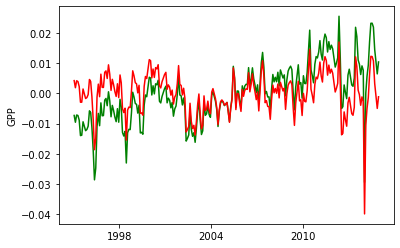

In [10]:
# now detrend data
dt_F = ds_anomF.get(var).map(signal.detrend)   # still need to use get so detrend works
dt_L = ds_anomL.get(var).map(signal.detrend)   

plt.plot(ds_anomL.time['time'], ds_anomL.get(var[0]), '-',c='green' )
plt.plot(ds_anomL.time['time'], dt_L.get(var[0]), '-' ,c='red')
plt.ylabel(var[0]);

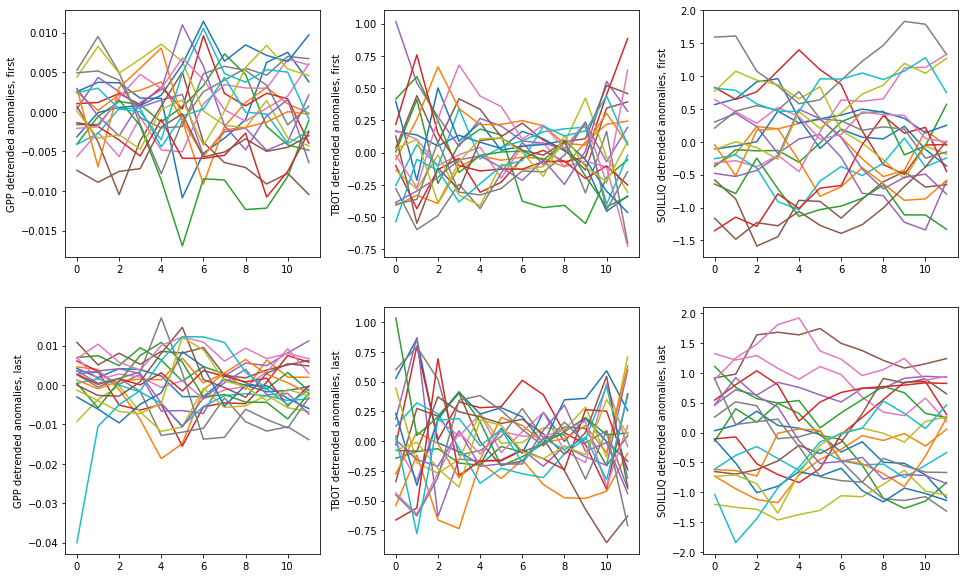

In [11]:
iavmatrixF =np.zeros([4, 12, years])
iavmatrixL =np.zeros([4, 12, years])
for i in range(4):
    for iyr in range(years):
        iavmatrixF[i, 0:12, iyr]=dt_F.get(var[i])[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
        iavmatrixL[i, 0:12, iyr]=dt_L.get(var[i])[iyr*12:(iyr+1)*12] 
        
plt.figure(figsize=[16,10])
for j in range(2):
    for i in range(3):
        if j == 0:
            plt.subplot(2, 3, (1+i))
            plt.ylabel(var[i]+' detrended anomalies, first')
            plt.plot(iavmatrixF[i,:,:]);
    
        if j == 1:
            plt.subplot(2, 3, (4+i))
            plt.ylabel(var[i]+' detrended anomalies, last')
            plt.plot(iavmatrixL[i,:,:]);

plt.subplots_adjust(wspace=0.25)


### Now try using SVD_tools.py
This code was provided by Gretchen Keppel-Aleks & initially developed by Zach Butterfield

Further modified by W. Wieder to accept matrix when years > 12 (nmonths)
- Decompose function accepts a month * year matrix and calculates vectors (dimensions = years,months) and weights (years,years)  
- Redistribution function takes vectors, weights, and matrix to calculate theta (years), & varfrac (years)

In [12]:
#assign the 2-D matrix (month x year) to decompose
#Call the function to calculate the singular vectors and their annual weights
vectorsF, weightsF=svd.decompose(iavmatrixF[0,:,:])   #TIME
thetaF ,varfracF  =svd.calc_redistribution(vectorsF , weightsF , iavmatrixF[0,:,:]) #TIME

vectorsL, weightsL=svd.decompose(iavmatrixL[0,:,:])   #TIME
thetaL ,varfracL  =svd.calc_redistribution(vectorsL , weightsL , iavmatrixL[0,:,:]) #TIME

print(vectorsF.shape)  #(nyears , nmonths)
print(weightsF.shape)
#print(ds_detrend_season) #(101 time slices, needs to be reshaped to nyears*season)

(20, 12)
(20, 20)


In [13]:
# Define what we want to look at:
mm2plot=ds_climL.get(var[0]) 
varfrac = varfracL
theta = thetaL
vectors =vectorsL 
weights =weightsL 


In [14]:
# also try spearman's rank correlation
s = np.zeros(years)
for i in range(years):
    s[i] = spearmanr(mm2plot,vectors[i,:])[0]
print('Spearmans correlation SV1 vectors ~ Climatology: %.3f' % s[0])
print('Spearmans correlation SV2 vectors ~ Climatology: %.3f' % s[1])

# also try weighting correlation based on monthly contribution to annual flux
wgt = mm2plot/mm2plot.sum()
def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

r = np.zeros(years)
for i in range(years):
    r[i] = corr(mm2plot.values,vectors[i,:], wgt.values)
    
print('weighted correlation SV1 vectors ~ Climatology: %.3f' % r[0])
print('weighted correlation SV2 vectors ~ Climatology: %.3f' % r[1])
## for our generic tropical plot, SV1 = early shift & SV2 = amplification

Spearmans correlation SV1 vectors ~ Climatology: -0.958
Spearmans correlation SV2 vectors ~ Climatology: -0.881
weighted correlation SV1 vectors ~ Climatology: -0.858
weighted correlation SV2 vectors ~ Climatology: -0.758


In [15]:
## add logicals to flip vectors and weights if:
# 1a) amplificaiton vector and correlation with climatology < 0
# 2) phase shift vector and minVector comes before maxVector
# 1b) amplificaiton vector and sum(vectors)<0 [this corrects issues in the tropics]

flip_corr = s<0  # here using spearmans

min_vector = np.argmin(vectors, axis=1)
max_vector = np.argmax(vectors, axis=1)
flip_vector = min_vector < max_vector
print(flip_vector)

# only flip corr where amplificaiton, vector where phase
if np.absolute(s[0])<np.absolute(s[1]):
    flip_corr[0] = False
    flip_vector[1] = False
else:
    flip_corr[1] = False
    flip_vector[0] = False

flip_vector = flip_corr + flip_vector
print(flip_vector)

for i in range(years):
    if flip_vector[i] == True:
        vectors[i,:] = -vectors[i,:]
        weights[i,:] = -weights[i,:]
        

[False False False  True  True False  True  True False False False  True
 False False False False False False False False]
[ True False  True  True  True False  True  True  True  True  True  True
 False False False False False False False False]


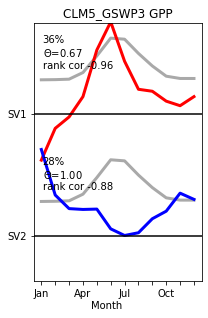

In [17]:
# Plot First and Second Singular Vectors
# TODO This is a pretty complicated plotting method that could likely be improved & made into a function
# That said, the it makes nice, clear plots... we'll keep it for now
ymax=np.max(vectors)
vectors2plot=vectors*10  #This is a totally arbitrary scale factor, 
#                           decided by me, to make figures look good!

fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'darkgray',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'darkgray',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'r-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'b-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.50,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0])+
        "\n"+str('rank cor %.2f' % s[0]))
ax1.text(0.5,.10,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1])+
        "\n"+str('rank cor %.2f' % s[1]))

ax1.title.set_text(model +' '+var[0])
ax1.text(4,-0.29,'Month')
plt.tight_layout();

